# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [18]:
#directory_data  = '/assignment_06_data.npz'
filename_data   = '/assignment_06_data.npz'
data            = np.load(os.path.join(filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

FileNotFoundError: ignored

## number of classes

In [14]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [63]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 100
learning_rate = 0.001
num_epoch = 100
weight_decay    = 0.001

In [64]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

## custom data loader for the PyTorch framework

In [65]:
mnist_train = dset.MNIST("./", train=True, 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ]),
    target_transform=None,
    download=True)
mnist_test = dset.MNIST("./", train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ]), target_transform=None, download=True)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

## construct datasets and dataloaders for training and testing

In [66]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [67]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([100, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([100])
************************************************************


## class for the neural network 

In [68]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           
            nn.Conv2d(32, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)        
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),            
            nn.Linear(64, 10),
        )       
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

## build network

In [69]:
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=0.1, patience=1, mode='min')

## print the defined neural network

In [70]:
print(CNN)

<class '__main__.CNN'>


## compute the prediction

In [71]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [72]:
def compute_loss(prediction, label):
    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [73]:
def compute_accuracy(prediction, label):
    y_pred = torch.argmax(prediction, dim=1)
    return (y_pred == label).to(torch.float).mean()

## variables for the learning curve

In [74]:
loss_mean_train     = np.zeros(num_epoch)
loss_std_train      = np.zeros(num_epoch)
accuracy_mean_train = np.zeros(num_epoch)
accuracy_std_train  = np.zeros(num_epoch)

loss_mean_test      = np.zeros(num_epoch)
loss_std_test       = np.zeros(num_epoch)
accuracy_mean_test  = np.zeros(num_epoch)
accuracy_std_test   = np.zeros(num_epoch)

## train and test

In [75]:
for i in tqdm(range(num_epoch)):
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    for _,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
      
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        accuacy_train = compute_accuracy(output, y_)
        
        loss_train_epoch.append(loss.item())
        accuracy_train_epoch.append(accuacy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    loss_test_epoch        = []
    accuracy_test_epoch    = []

    model.eval()
    for _,[image_test,label_test] in enumerate(test_loader):
        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        output_test = model.forward(image_test)
        loss_test = loss_func(output_test, label_test)
        accuracy_test = compute_accuracy(output_test, label_test)
        loss_test_epoch.append(loss_test.item())
        accuracy_test_epoch.append(accuracy_test)
    
    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test_epoch)
    accuracy_std_test[i]   = np.std(accuracy_test_epoch)

100%|██████████| 100/100 [3:52:19<00:00, 139.40s/it]


## plot curve

In [1]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [2]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [3]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [4]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [5]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [6]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [7]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [8]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [9]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [10]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [11]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [12]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [13]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [14]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [15]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

In [16]:
function_result_01()

NameError: ignored

## # 02. plot the training accuracy curve (mean, std)

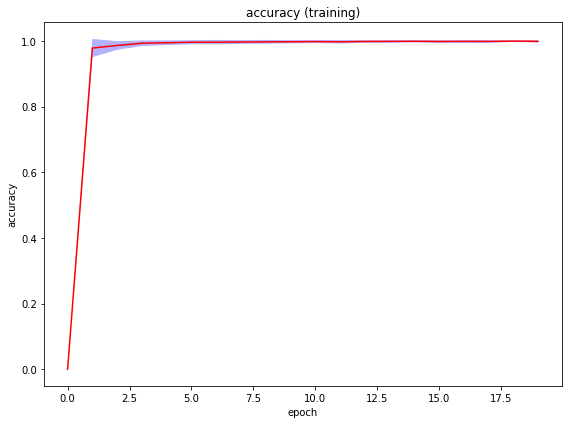

In [54]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

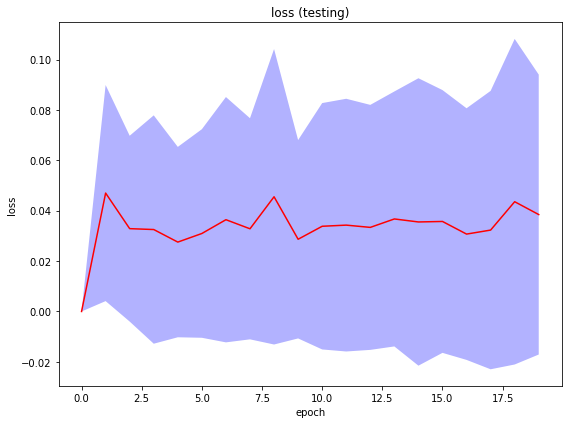

In [55]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

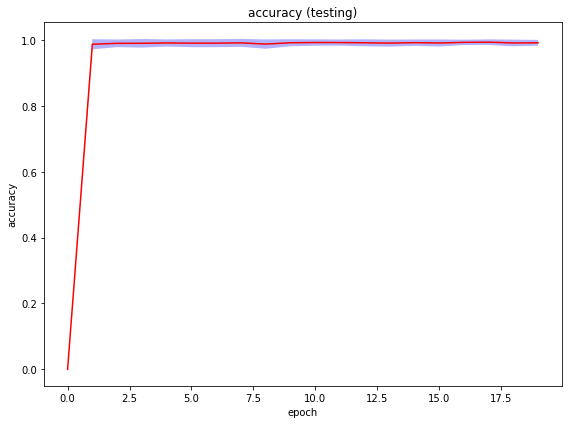

In [56]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [57]:
function_result_05()

index =  0, value = 0.0063144856
index =  1, value = 0.0077946375
index =  2, value = 0.0048363090
index =  3, value = 0.0049058735
index =  4, value = 0.0041984257
index =  5, value = 0.0058577641
index =  6, value = 0.0047087411
index =  7, value = 0.0045563782
index =  8, value = 0.0018619496
index =  9, value = 0.0049593764


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [58]:
function_result_06()

index =  0, value = 0.9980165362
index =  1, value = 0.9973665476
index =  2, value = 0.9983166456
index =  3, value = 0.9984833002
index =  4, value = 0.9989000559
index =  5, value = 0.9982332587
index =  6, value = 0.9984666109
index =  7, value = 0.9983665943
index =  8, value = 0.9994167089
index =  9, value = 0.9986832738


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [59]:
function_result_07()

index =  0, value = 0.0338219983
index =  1, value = 0.0342727763
index =  2, value = 0.0333780049
index =  3, value = 0.0367240548
index =  4, value = 0.0355313963
index =  5, value = 0.0357272990
index =  6, value = 0.0307183266
index =  7, value = 0.0323057174
index =  8, value = 0.0435667478
index =  9, value = 0.0384640074


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [60]:
function_result_08()

index =  0, value = 0.9925999641
index =  1, value = 0.9924999475
index =  2, value = 0.9918000102
index =  3, value = 0.9907999635
index =  4, value = 0.9921999574
index =  5, value = 0.9912000299
index =  6, value = 0.9931000471
index =  7, value = 0.9936999679
index =  8, value = 0.9912999868
index =  9, value = 0.9918000102


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [61]:
function_result_09()

best training accuracy = 0.9994167089


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [62]:
function_result_10()

best testing accuracy = 0.9936999679
